<a href="https://colab.research.google.com/github/svasylyeva/AWS/blob/main/Code_128px_35_folders_FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
# Importing the Keras libraries and packages
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers.core import Dense, Dropout, Activation, Flatten

from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import tensorflow
from sklearn.metrics import classification_report, confusion_matrix
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from numpy.random import seed
import os
from shutil import copy2
from tqdm import tqdm
from PIL import Image
import PIL
import random
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization 

# import splitfolders library to split folder with chosen ratio
#import splitfolders
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import Model
from matplotlib import pyplot
from numpy import expand_dims

<h3>Pre-processing Part</h3>


In [ ]:
# Pre-processing Part
# Copy files from a set of folders inside downloaded artist to one folder for every artist

# Wikiart script downloads files to the local drive
root_dir = '/Users/murmu/Documents/Deep_Learning/wikiart/wikiart-master/wikiart-saved/images/'
destination_dir = '/Users/murmu/Documents/Deep_Learning/wikiart/wikiart-master/artists/'

# Download pictures with wikiart code from WikiArt and create folders with chosen artists
# link to github project - https://github.com/lucasdavid/wikiart
# We do not show code of the script for downloading here - it could be found on the link above

# Folders of artist after wikiart work
src_artist_lst = [ 'camille-pissarro', 'claude-monet', 
                  'henri-matisse', 'pierre-auguste-renoir', 'vincent-van-gogh', 'john-singer-sargent']

# Folders of artists that we are going to use in the further work
dest_artist_lst = ['Pissaro', 'Monet', 'Matisse', 'Renoir', 'VanGogh', 'Sargent']

# Define function to copy jpegs from folders that wikiart script created on local drive
def copy_jpegs(src_artist, dest_artist):
# Define source and destination directories
    artist_src_dir = os.path.join(root_dir, src_artist)
    artist_destination_dir = os.path.join(destination_dir, dest_artist)

# Copy files from all directories inside main directory with the name of artist
# showing progress bar of the process
    for root, dirs, files in os.walk(artist_src_dir):
        for file in tqdm(files):
            path_file = os.path.join(root, file)
            source_resized_file = os.path.join(artist_destination_dir, file)

# To resize our files and avoid stretching for rectangular files we used AlexNet pre-processing approach:
# - down-sample the images to a fixed resolution of 256 × 256
# - for rectangular image, we first rescaled the image such that the shorter side was of length 256 and
# cropped out the central 256×256 part from the resulting image
            max_side = 256
            image = Image.open(path_file)
            w, h = image.size
            original_size = max(w, h)

            # If image has a rectangular shape - resize it such way 
            # that the shortest side of the image becomes 256px and crop the center
            if (w < h):
                resized_width = max_side
                resized_height = int(round((max_side/float(image.size[0]))*image.size[1]))
                # resixe image
                image = image.resize((resized_width, resized_height), Image.ANTIALIAS)
                left = 0
                top = (resized_height - max_side)/2
                right = max_side
                bottom = (resized_height + max_side)/2
                image = image.crop((left, top, right, bottom))
            else:
                resized_height = max_side
                resized_width = int(round((max_side/float(image.size[1]))*image.size[0]))
                # resixe image
                image = image.resize((resized_width, resized_height), Image.ANTIALIAS)
                left = (resized_width - max_side)/2
                top = 0
                right = (resized_width + max_side)/2
                bottom = max_side
                image = image.crop((left, top, right, bottom))
            
            # convert to RGB incase it's RGBA
            cropped_rgb_image = image.convert("RGB")
            # save resized image
            cropped_rgb_image.save(source_resized_file, image.format)

        
# Create a zip list 
zip_lst = list(zip(src_artist_lst, dest_artist_lst))

# copy files
for (src, dest) in zip_lst: 
    copy_jpegs(src, dest)

0it [00:00, ?it/s]
100%|██████████| 71/71 [00:02<00:00, 32.26it/s]
0it [00:00, ?it/s]
100%|██████████| 9/9 [00:00<00:00, 32.94it/s]
0it [00:00, ?it/s]
100%|██████████| 11/11 [00:00<00:00, 29.84it/s]


100%|██████████| 32/32 [00:01<00:00, 17.17it/s]
0it [00:00, ?it/s]
100%|██████████| 249/249 [00:08<00:00, 30.90it/s]
0it [00:00, ?it/s]
100%|██████████| 238/238 [00:11<00:00, 20.67it/s]
0it [00:00, ?it/s]
100%|██████████| 45/45 [00:00<00:00, 61.50it/s]


In [10]:
# We begin to work with images of size 128*128px for 30 epochs
# for our baseline models
img_rows = 128
img_cols = 128
epochs = 30
batch_size = 64

In [11]:
# Plot diagnostic learning curves from history
def graph_accuracy_loss(history):
    pyplot.figure(figsize=(10,5))
    # Plot loss
    pyplot.subplot(121)
    pyplot.title('Entropy Loss')
    pyplot.plot(history.history['loss'], color='green', label='train')
    pyplot.plot(history.history['val_loss'], color='blue', label='test')
    pyplot.legend()
    # Plot accuracy
    pyplot.subplot(122)
    pyplot.title('\nClassification Accuracy')
    pyplot.plot(history.history['accuracy'], color='green', label='train')
    pyplot.plot(history.history['val_accuracy'], color='blue', label='test')
    pyplot.legend()
    # Show plot
    pyplot.show()

In [12]:
# Function that calculates Confusion Matrix and shows Classification Report
def class_report(test_set, model):
# Predict with our model
    Y_pred = model.predict(test_set, num_of_test_samples // batch_size + 1)
    y_pred = np.argmax(Y_pred, axis=1)
    print('Confusion Matrix')
# Use confusion_matrix from sklearn
    print(confusion_matrix(test_set.classes, y_pred))
    print('Classification Report')
    target_names = list(training_set.class_indices.keys())
    print(classification_report(test_set.classes, y_pred, target_names=target_names))

In [ ]:
# Import and work with splitfolders 
#link - https://pypi.org/project/split-folders/

# Divide all artists folders to train and val folders
splitfolders.ratio("./artists", output="./", seed=42 , ratio=(.7, .3))

Copying files: 4800 files [00:36, 130.89 files/s]


In [13]:
# Prepare the data. Instanciate ImageDataGenerator that generates batches of image data 
# scaling the pixel values to the range of 0-1.
# We don't use data augmentation, dropout etc for the Baseline models to check a minimal model performance 
datagen = ImageDataGenerator(rescale=1. / 255)

# Use train folder that was created with splitfolders for creating training set
training_set = datagen.flow_from_directory('train', 
                                                 target_size=(img_rows, img_cols),
                                                 batch_size=batch_size,
                                                 class_mode='categorical')

# Use val folder that was created with splitfolders for creating validation set
test_set = datagen.flow_from_directory('val',
                                            target_size=(img_rows, img_cols),
                                            batch_size=batch_size, shuffle = False,
                                            class_mode='categorical')

Found 3360 images belonging to 6 classes.
Found 1440 images belonging to 6 classes.


In [14]:
# Define number of samnples for train and test sets
num_of_train_samples = training_set.n
num_of_test_samples = test_set.n

In [ ]:
# Print our classes 
print(test_set.class_indices)

{'Matisse': 0, 'Monet': 1, 'Pissaro': 2, 'Renoir': 3, 'Sargent': 4, 'VanGogh': 5}


(64, 128, 128, 3)
(64, 6)


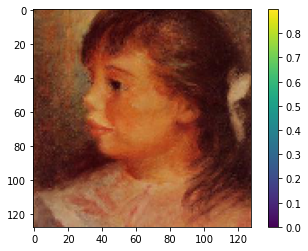

In [ ]:
# Show a random picture from training set

# Define images array
image_train = []
# Define images labels
labels_train = []

for i, l in training_set:
    image_train = i
    print(image_train.shape)
    labels_train = l
    print(labels_train.shape)
    
    # only to show if it is working
    plt.figure()
    plt.imshow(image_train[0])
    plt.colorbar()
    plt.grid(False)
    plt.show()
    
    break

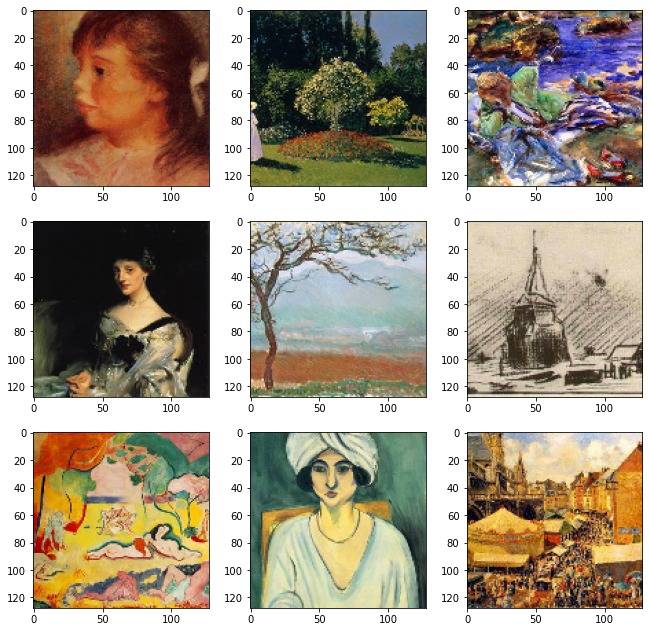

In [ ]:
#Show 9 random pictures in train data
rows = 3
cols = 3
axes=[]
fig=plt.figure(figsize=(11,11))

for a in range(rows*cols):
    
    axes.append( fig.add_subplot(rows, cols, a+1) )

    plt.imshow(image_train[a])
#fig.tight_layout()    
plt.show()

In [ ]:
# VGG Blocks
# One VGG block consists of a sequence of convolutional layers, followed by a max pooling layer for spatial downsampling. 
# The authors employed convolutions with  3×3  kernels with padding of 1 (keeping height and width) 
# and  2×2  max pooling with stride of 2 (halving the resolution after each block). 

<h3>Baseline model with 1 VGG block without dropout</h3>


In [ ]:
# Part 1 - Develop a Baseline CNN Models:
# Define CNN model with one VGG-style block
# The 1-block VGG model has a single convolutional layer with 32 filters 
# followed by a max pooling layer
def baseline_model_1():
    
    model = Sequential()
# Add two 2D convolution layers with 32 filters. 
# Each Conv2D layer will have the ReLU activation and the “he_uniform” weight initialization (generally best practices)
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', 
                     input_shape=(img_rows, img_cols, 3)))
    model.add(Conv2D(32,(3,3), activation = 'relu', kernel_initializer = 'he_uniform', padding = 'same'))
# Add MaxPooling layer for downsampling
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    
    model.add(Flatten())
# Fully-connected layers
    model.add(Dense(128, activation='relu', 
                    kernel_initializer='he_uniform'))
    model.add(Dense(6, activation='softmax'))
    
# Compilation of a model    
# The model will be optimized using stochastic gradient descent. 
# with a learning rate of 0.001 and a momentum of 0.9. 
    opt = SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
# The model will be fit for 30 epochs - to check model's accuracy
# Define model
model = baseline_model_1()
# Fit model
history = model.fit_generator(training_set, 
                              steps_per_epoch=len(training_set), # = num_of_train_samples // batch_size +1
                              validation_data=test_set, 
                              validation_steps=len(test_set), # = num_of_test_samples // batch_size +1
                              epochs= epochs)

Epoch 1/35
53/53 [==============================] - 74s 1s/step - loss: 1.9967 - accuracy: 0.2219 - val_loss: 1.6657 - val_accuracy: 0.3076
Epoch 2/35
53/53 [==============================] - 56s 1s/step - loss: 1.5780 - accuracy: 0.3796 - val_loss: 1.4520 - val_accuracy: 0.4535
Epoch 3/35
53/53 [==============================] - 56s 1s/step - loss: 1.4486 - accuracy: 0.4522 - val_loss: 1.4351 - val_accuracy: 0.4556
Epoch 4/35
53/53 [==============================] - 56s 1s/step - loss: 1.3848 - accuracy: 0.4798 - val_loss: 1.3873 - val_accuracy: 0.4653
Epoch 5/35
53/53 [==============================] - 58s 1s/step - loss: 1.2973 - accuracy: 0.5251 - val_loss: 1.3587 - val_accuracy: 0.4847
Epoch 6/35
53/53 [==============================] - 56s 1s/step - loss: 1.2096 - accuracy: 0.5822 - val_loss: 1.3505 - val_accuracy: 0.4938
Epoch 7/35
53/53 [==============================] - 54s 1s/step - loss: 1.1968 - accuracy: 0.5805 - val_loss: 1.3719 - val_accuracy: 0.4708
Epoch 8/35
53/53 [==

In [ ]:
# Evaluate model
_, acc = model.evaluate_generator(test_set, steps=len(test_set), verbose=0)
print("Accuracy: %.4f" % (acc * 100.0))

Accuracy: 51.1806


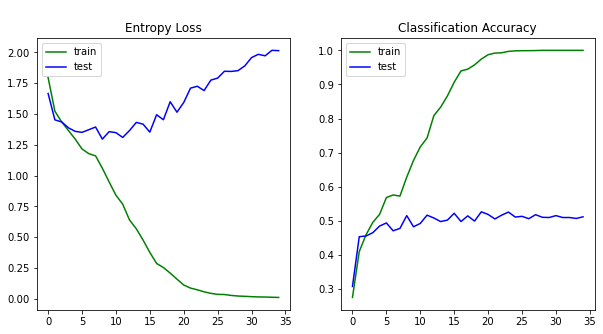

In [ ]:
# Build graphs of entropy loss and accuracy
graph_accuracy_loss(history)

In [ ]:
# Build a classification report
class_report(test_set, model)

Confusion Matrix
[[109  37  15  32  21  26]
 [ 16 129  40   8  11  36]
 [ 12  33 134  24  11  26]
 [ 17  14  20 139  22  28]
 [ 38  19  20  33 110  20]
 [ 18  22  36  31  17 116]]
Classification Report
              precision    recall  f1-score   support

     Matisse       0.52      0.45      0.48       240
       Monet       0.51      0.54      0.52       240
     Pissaro       0.51      0.56      0.53       240
      Renoir       0.52      0.58      0.55       240
     Sargent       0.57      0.46      0.51       240
     VanGogh       0.46      0.48      0.47       240

    accuracy                           0.51      1440
   macro avg       0.51      0.51      0.51      1440
weighted avg       0.51      0.51      0.51      1440



In [ ]:
# As we see our 1-vgg block model is over-fitting on a training set

<h3>Baseline model with 2 VGG blocks without dropout</h3>


In [ ]:
# Define CNN model with two VGG-style blocks according to the principle explained earlier
def baseline_model_2():
   # reset_random_seeds()
    model = Sequential()
# 1st block    
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', 
                     input_shape=(img_rows, img_cols, 3)))
    model.add(Conv2D(32,(3,3), activation = 'relu', kernel_initializer = 'he_uniform', padding = 'same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

# 2d block    
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(64,(3,3), activation = 'relu', kernel_initializer = 'he_uniform', padding = 'same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
   
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(6, activation='softmax'))
# Compilation of a model
    opt = SGD(lr=0.001, momentum=0.9) # Gradient descent (with momentum) optimizer.
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
# The model will be fit for 30 epochs 
# define model
model = baseline_model_2()
# fit model
history = model.fit_generator(training_set, steps_per_epoch=len(training_set),
                              validation_data=test_set, 
                              validation_steps=len(test_set), 
                              epochs= epochs)

Epoch 1/25
53/53 [==============================] - 95s 2s/step - loss: 1.8804 - accuracy: 0.2391 - val_loss: 1.5255 - val_accuracy: 0.4465
Epoch 2/25
53/53 [==============================] - 93s 2s/step - loss: 1.4949 - accuracy: 0.4416 - val_loss: 1.5273 - val_accuracy: 0.3806
Epoch 3/25
53/53 [==============================] - 94s 2s/step - loss: 1.4085 - accuracy: 0.4545 - val_loss: 1.3900 - val_accuracy: 0.4938
Epoch 4/25
53/53 [==============================] - 94s 2s/step - loss: 1.3073 - accuracy: 0.5134 - val_loss: 1.3347 - val_accuracy: 0.4944
Epoch 5/25
53/53 [==============================] - 92s 2s/step - loss: 1.1953 - accuracy: 0.5544 - val_loss: 1.3934 - val_accuracy: 0.5201
Epoch 6/25
53/53 [==============================] - 93s 2s/step - loss: 1.1147 - accuracy: 0.5967 - val_loss: 1.2434 - val_accuracy: 0.5465
Epoch 7/25
53/53 [==============================] - 92s 2s/step - loss: 0.9786 - accuracy: 0.6673 - val_loss: 1.3812 - val_accuracy: 0.4646
Epoch 8/25
53/53 [==

In [ ]:
# Evaluate model
_, acc = model.evaluate_generator(test_set, steps=len(test_set), verbose=0)
print("Accuracy: %.4f" % (acc * 100.0))

Accuracy: 54.5139


In [ ]:
# Build a classification report
class_report(test_set, model)

Confusion Matrix
[[147   8  15  30  19  21]
 [ 23 121  45  16  16  19]
 [ 24  17 157  18   8  16]
 [ 32   9  20 139  24  16]
 [ 54   7  26  29 112  12]
 [ 27  10  49  25  20 109]]
Classification Report
              precision    recall  f1-score   support

     Matisse       0.48      0.61      0.54       240
       Monet       0.70      0.50      0.59       240
     Pissaro       0.50      0.65      0.57       240
      Renoir       0.54      0.58      0.56       240
     Sargent       0.56      0.47      0.51       240
     VanGogh       0.56      0.45      0.50       240

    accuracy                           0.55      1440
   macro avg       0.56      0.55      0.54      1440
weighted avg       0.56      0.55      0.54      1440



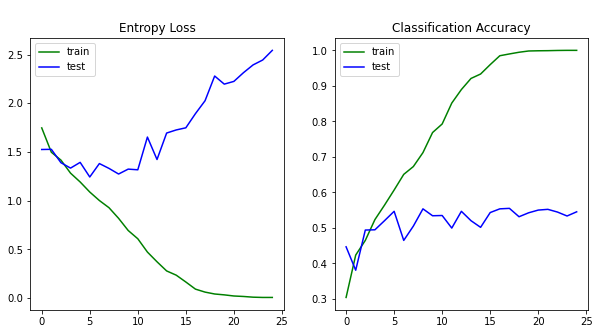

In [ ]:
# Build graphs of entropy loss and accuracy
graph_accuracy_loss(histvory)

In [ ]:
# As we see our 2-vgg block model is over-fitting on a training set as well

<h3>Baseline model with 3 VGG blocks without dropout</h3>


In [ ]:
# Define CNN model with three VGG-style blocks according to the principle explained earlier
def baseline_model_3():
    #reset_random_seeds()
    model = Sequential()
# 1st block    
    model.add(Conv2D(32, (3, 3), activation='relu', 
                     kernel_initializer='he_uniform', 
                     padding='same', input_shape=(img_rows, img_cols, 3)))
    model.add(Conv2D(32,(3,3), activation = 'relu', kernel_initializer = 'he_uniform', padding = 'same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
# 2d block    
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(64,(3,3), activation = 'relu', kernel_initializer = 'he_uniform', padding = 'same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
# 3d block
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(128,(3,3), activation = 'relu', kernel_initializer = 'he_uniform', padding = 'same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
   
    model.add(Flatten())
    model.add(Dense(128, activation='relu', 
                    kernel_initializer='he_uniform'))
    model.add(Dense(6, activation='softmax'))
# Compilation of a model
    opt = SGD(lr=0.001, momentum=0.9) # Gradient descent (with momentum) optimizer.
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
# The model will be fit for 20 epochs - to check if the model can learn the problem.
# Define model
model = baseline_model_3()
# Fit model
history = model.fit_generator(training_set, steps_per_epoch=len(training_set),
                              validation_data=test_set, 
                              validation_steps=len(test_set), 
                              epochs= 25)

Epoch 1/25
53/53 [==============================] - 120s 2s/step - loss: 1.8064 - accuracy: 0.2054 - val_loss: 1.6606 - val_accuracy: 0.3118
Epoch 2/25
53/53 [==============================] - 121s 2s/step - loss: 1.5919 - accuracy: 0.3569 - val_loss: 1.5015 - val_accuracy: 0.4056
Epoch 3/25
53/53 [==============================] - 119s 2s/step - loss: 1.4809 - accuracy: 0.4258 - val_loss: 1.3783 - val_accuracy: 0.4646
Epoch 4/25
53/53 [==============================] - 119s 2s/step - loss: 1.3954 - accuracy: 0.4787 - val_loss: 1.3719 - val_accuracy: 0.4819
Epoch 5/25
53/53 [==============================] - 119s 2s/step - loss: 1.2992 - accuracy: 0.5075 - val_loss: 1.3322 - val_accuracy: 0.4958
Epoch 6/25
53/53 [==============================] - 117s 2s/step - loss: 1.2359 - accuracy: 0.5437 - val_loss: 1.4353 - val_accuracy: 0.4549
Epoch 7/25
53/53 [==============================] - 119s 2s/step - loss: 1.3134 - accuracy: 0.5079 - val_loss: 1.3522 - val_accuracy: 0.4958
Epoch 8/25
53

In [ ]:
# Evaluate model
_, acc = model.evaluate_generator(test_set, steps=len(test_set), verbose=0)
print("Accuracy: %.4f" % (acc * 100.0))

Accuracy: 55.3472


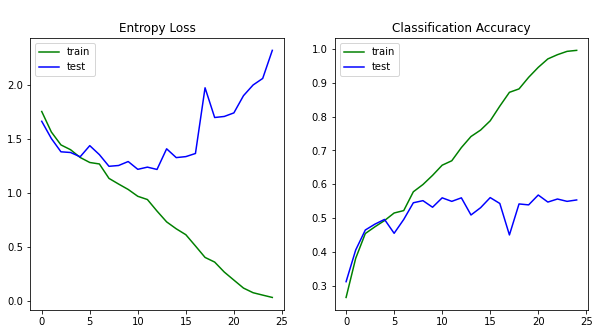

In [ ]:
# Build graphs of entropy loss and accuracy
graph_accuracy_loss(history)

In [ ]:
# Build a classification report
class_report(test_set, model)

Confusion Matrix
[[151  16  12  32  15  14]
 [ 17 148  25  14   8  28]
 [ 23  26 120  22   5  44]
 [ 19  13   9 167  11  21]
 [ 41  19  12  58  88  22]
 [ 24  25  29  29  10 123]]
Classification Report
              precision    recall  f1-score   support

     Matisse       0.55      0.63      0.59       240
       Monet       0.60      0.62      0.61       240
     Pissaro       0.58      0.50      0.54       240
      Renoir       0.52      0.70      0.59       240
     Sargent       0.64      0.37      0.47       240
     VanGogh       0.49      0.51      0.50       240

    accuracy                           0.55      1440
   macro avg       0.56      0.55      0.55      1440
weighted avg       0.56      0.55      0.55      1440



In [ ]:
# Accuracy score for 3 VGG blocks is higher than for 2 vgg blcoks model, 
# so we will continiue with it.
# We still have an over-fitting so we will add a dropout regularizatiom

In [ ]:
# Part 2 - Add Dropout Regularization and Data Augmentation
# to our Baseline model step by step and evaluate an efficiency  
# ___________________________________________________________


# 1 step - Add Dropout

<h3>Model with 3 VGG blocks with dropout</h3>

In [15]:
# Prepare the data. Instanciate ImageDataGenerator that scalse the pixel values to the range of 0-1
# We don't use data augmentation for this moment 
datagen = ImageDataGenerator(rescale=1. / 255)

training_set = datagen.flow_from_directory('train', target_size=(img_rows, img_cols),
                                                 batch_size=batch_size,
                                                 class_mode='categorical')

test_set = datagen.flow_from_directory('val',target_size=(img_rows, img_cols),
                                            batch_size=batch_size, shuffle = False,
                                            class_mode='categorical')

Found 3360 images belonging to 6 classes.
Found 1440 images belonging to 6 classes.


In [16]:
# Define CNN model with Dropout Regularization using 3 VGG blocks model
def model_with_dropout():
    model = Sequential()
   
    # 1st block    
    model.add(Conv2D(32, (3, 3), activation='relu', 
                     kernel_initializer='he_uniform', 
                     padding='same', input_shape=(img_rows, img_cols, 3)))
    model.add(Conv2D(32,(3,3), activation = 'relu', kernel_initializer = 'he_uniform', padding = 'same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    
# 2d block    
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(64,(3,3), activation = 'relu', kernel_initializer = 'he_uniform', padding = 'same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    
# 3d block
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(128,(3,3), activation = 'relu', kernel_initializer = 'he_uniform', padding = 'same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
   
    model.add(Flatten())
    model.add(Dense(128, activation='relu', 
                    kernel_initializer='he_uniform'))
# Dropout 0.5 was added meaning that 50% of the nodes will be ignored
    model.add(Dropout(0.5))
    model.add(Dense(6, activation='softmax'))
    # Compilation of a model
    opt = SGD(lr=0.001, momentum=0.9) # Gradient descent (with momentum) optimizer.
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [17]:
# The model will be fit for 30 epochs 
# Define model
model_d = model_with_dropout()
# Fit model
history = model_d.fit_generator(training_set, steps_per_epoch=len(training_set),
                                validation_data=test_set,
                                validation_steps=len(test_set), 
                                epochs= epochs)

Epoch 1/30
53/53 [==============================] - 44s 178ms/step - loss: 1.8069 - accuracy: 0.2356 - val_loss: 1.5814 - val_accuracy: 0.4000
Epoch 2/30
53/53 [==============================] - 8s 150ms/step - loss: 1.6245 - accuracy: 0.3408 - val_loss: 1.4526 - val_accuracy: 0.4563
Epoch 3/30
53/53 [==============================] - 8s 148ms/step - loss: 1.5109 - accuracy: 0.4194 - val_loss: 1.4159 - val_accuracy: 0.4854
Epoch 4/30
53/53 [==============================] - 8s 147ms/step - loss: 1.5126 - accuracy: 0.4131 - val_loss: 1.4531 - val_accuracy: 0.4625
Epoch 5/30
53/53 [==============================] - 8s 148ms/step - loss: 1.4632 - accuracy: 0.4358 - val_loss: 1.3955 - val_accuracy: 0.4694
Epoch 6/30
53/53 [==============================] - 8s 148ms/step - loss: 1.4167 - accuracy: 0.4476 - val_loss: 1.3418 - val_accuracy: 0.4965
Epoch 7/30
53/53 [==============================] - 8s 155ms/step - loss: 1.3404 - accuracy: 0.4911 - val_loss: 1.3372 - val_accuracy: 0.5097
Epoch

In [18]:
# Evaluate model
_, acc = model_d.evaluate_generator(test_set, steps=len(test_set), verbose=0)
print("Accuracy: %.4f" % (acc * 100.0))

Accuracy: 57.9167


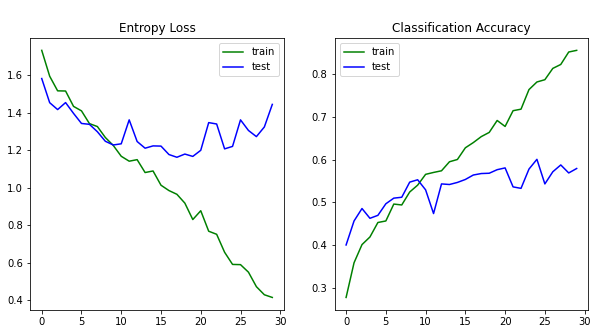

In [19]:
# Build graphs of entropy loss and accuracy
graph_accuracy_loss(history)

In [ ]:
# As we see model overfitts less after usage of dropout

In [ ]:
# Build a classification report
class_report(test_set, model_d)

Confusion Matrix
[[178   7   8  10  24  13]
 [ 19 144  33   9  19  16]
 [ 16  28 142  19  14  21]
 [ 21  17  22 145  23  12]
 [ 50   8   9  25 138  10]
 [ 21  24  36  13  28 118]]
Classification Report
              precision    recall  f1-score   support

     Matisse       0.58      0.74      0.65       240
       Monet       0.63      0.60      0.62       240
     Pissaro       0.57      0.59      0.58       240
      Renoir       0.66      0.60      0.63       240
     Sargent       0.56      0.57      0.57       240
     VanGogh       0.62      0.49      0.55       240

    accuracy                           0.60      1440
   macro avg       0.60      0.60      0.60      1440
weighted avg       0.60      0.60      0.60      1440



In [ ]:
# 2 step - Add Data augmentation
# Use our 3 VGG blocks model with dropout

<h3>Model with 3 VGG blocks with dropout and data augmentation</h3>


<h4>Trained for max 85 epochs with dropout and data augmentation (with Early Stopping and saving the best model)</h4>


In [23]:
# Implementing Early stoping and checkpoint to save the model with the highest accuracy
ES = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
# Save chekpoints to best_model.h5
MC = ModelCheckpoint('best_model.h5', monitor='val_accuracy', verbose=1, save_best_only=True, 
                     save_weights_only=False, mode='auto')

In [24]:
# Create data generators with data augmentation (different zooming, horizontal flip and shear intensity)
train_datagen = ImageDataGenerator(rescale=1. / 255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')
# We do not use data augmentation for test dataset, only normalize pixels
test_datagen = ImageDataGenerator(rescale=1. / 255)

# Create sets
training_set = train_datagen.flow_from_directory('train',
                                                 target_size=(img_rows, img_cols),
                                                 batch_size=batch_size,
                                                 class_mode='categorical')


test_set = test_datagen.flow_from_directory('val',
                                            target_size=(img_rows, img_cols),
                                            batch_size=batch_size, shuffle = False,
                                            class_mode='categorical')

# Define model
model_dropout_dataaugm = model_with_dropout()
# Fit model
history = model_dropout_dataaugm.fit_generator(training_set, 
                              steps_per_epoch=len(training_set),
                              validation_data=test_set, 
                              validation_steps=len(test_set), 
                              epochs= 85, callbacks=[ES, MC])

Found 3360 images belonging to 6 classes.
Found 1440 images belonging to 6 classes.
Epoch 1/85
53/53 [==============================] - 19s 343ms/step - loss: 1.9072 - accuracy: 0.1760 - val_loss: 1.7420 - val_accuracy: 0.3326

Epoch 00001: val_accuracy improved from -inf to 0.33264, saving model to best_model.h5
Epoch 2/85
53/53 [==============================] - 18s 340ms/step - loss: 1.7360 - accuracy: 0.2781 - val_loss: 1.6481 - val_accuracy: 0.3833

Epoch 00002: val_accuracy improved from 0.33264 to 0.38333, saving model to best_model.h5
Epoch 3/85
53/53 [==============================] - 18s 334ms/step - loss: 1.6649 - accuracy: 0.3283 - val_loss: 1.5779 - val_accuracy: 0.4153

Epoch 00003: val_accuracy improved from 0.38333 to 0.41528, saving model to best_model.h5
Epoch 4/85
53/53 [==============================] - 18s 337ms/step - loss: 1.5980 - accuracy: 0.3755 - val_loss: 1.4965 - val_accuracy: 0.4306

Epoch 00004: val_accuracy improved from 0.41528 to 0.43056, saving model 

In [25]:
# Create a new model instance to upload the best saved model there
# because our trained model finished training with the final accuracy not the best possible
model_best = model_with_dropout()


model_best.load_weights('best_model.h5')
# Evaluate model

_, acc = model_best.evaluate_generator(test_set, steps=len(test_set), verbose=0)
print("Best accuracy: %.4f" % (acc * 100.0))

Best accuracy: 63.9583


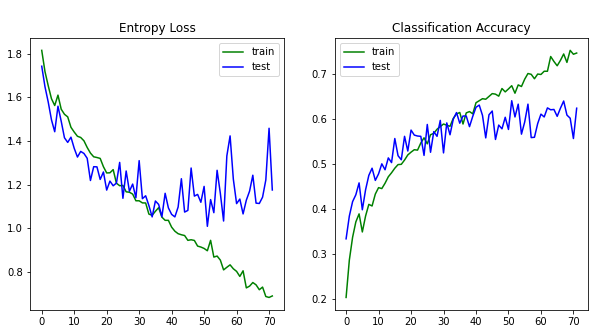

In [26]:
# Build graphs of entropy loss and accuracy
graph_accuracy_loss(history)

<h4>Trained for max 85 epochs and bigger size of pictures (224*224px instead 128*128px) and Early Stopping</h4>

In [ ]:
# Implementing Early stoping and checkpoint to save the model with the highest accuracy
ES = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
# Save chekpoints to best_model_224px.h5
MC = ModelCheckpoint('best_model_224px.h5', monitor='val_accuracy', verbose=1, save_best_only=True, 
                     save_weights_only=False, mode='auto')

In [ ]:
# Let's try to change pictures size from 128 to 224px and check accuracy
# Create data generators according to the principle as before
train_datagen = ImageDataGenerator(rescale=1. / 255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')
# We do not use data augmentation for test dataset, only normalize pixels
test_datagen = ImageDataGenerator(rescale=1. / 255)

img_rows = 224
img_cols = 224
# Create sets
training_set = train_datagen.flow_from_directory('train',
                                                 target_size=(img_rows, img_cols),
                                                 batch_size=batch_size,
                                                 class_mode='categorical')


test_set = test_datagen.flow_from_directory('val',
                                            target_size=(img_rows, img_cols),
                                            batch_size=batch_size, shuffle = False,
                                            class_mode='categorical')

# Define model
model224 = model_with_dropout()
# Fit model
history = model224.fit_generator(training_set, 
                              steps_per_epoch=len(training_set),
                              validation_data=test_set, 
                              validation_steps=len(test_set), 
                              epochs= 85, callbacks=[ES, MC])

Found 3360 images belonging to 6 classes.
Found 1440 images belonging to 6 classes.
Epoch 1/85
53/53 [==============================] - 327s 6s/step - loss: 1.8328 - accuracy: 0.2140 - val_loss: 1.6944 - val_accuracy: 0.2639

Epoch 00001: val_accuracy improved from -inf to 0.26389, saving model to best_model_224px.h5
Epoch 2/85
53/53 [==============================] - 328s 6s/step - loss: 1.6909 - accuracy: 0.2965 - val_loss: 1.5895 - val_accuracy: 0.3778

Epoch 00002: val_accuracy improved from 0.26389 to 0.37778, saving model to best_model_224px.h5
Epoch 3/85
53/53 [==============================] - 327s 6s/step - loss: 1.6376 - accuracy: 0.3441 - val_loss: 1.5510 - val_accuracy: 0.4111

Epoch 00003: val_accuracy improved from 0.37778 to 0.41111, saving model to best_model_224px.h5
Epoch 4/85
53/53 [==============================] - 329s 6s/step - loss: 1.6085 - accuracy: 0.3495 - val_loss: 1.4963 - val_accuracy: 0.4500

Epoch 00004: val_accuracy improved from 0.41111 to 0.45000, sav


Epoch 00038: val_accuracy did not improve from 0.62708
Epoch 39/85
53/53 [==============================] - 338s 6s/step - loss: 0.9078 - accuracy: 0.6590 - val_loss: 1.2670 - val_accuracy: 0.5562

Epoch 00039: val_accuracy did not improve from 0.62708
Epoch 40/85
53/53 [==============================] - 336s 6s/step - loss: 0.9214 - accuracy: 0.6514 - val_loss: 1.0842 - val_accuracy: 0.6028

Epoch 00040: val_accuracy did not improve from 0.62708
Epoch 41/85
53/53 [==============================] - 334s 6s/step - loss: 0.8847 - accuracy: 0.6732 - val_loss: 1.1661 - val_accuracy: 0.5819

Epoch 00041: val_accuracy did not improve from 0.62708
Epoch 42/85
53/53 [==============================] - 343s 6s/step - loss: 0.8506 - accuracy: 0.6828 - val_loss: 1.0871 - val_accuracy: 0.6215

Epoch 00042: val_accuracy did not improve from 0.62708
Epoch 43/85
53/53 [==============================] - 339s 6s/step - loss: 0.9311 - accuracy: 0.6597 - val_loss: 1.1820 - val_accuracy: 0.5882

Epoch 000

In [ ]:
# Create a new model instance to upload the best saved model there
# because our trained model finished training with the final accuracy not the best possible
model = model_with_dropout()

# Load the previously saved weights
model.load_weights('best_model_224px.h5')
# Evaluate model

_, acc = model.evaluate_generator(test_set, steps=len(test_set), verbose=0)
print("Best accuracy: %.4f" % (acc * 100.0))

Accuracy: 62.9167


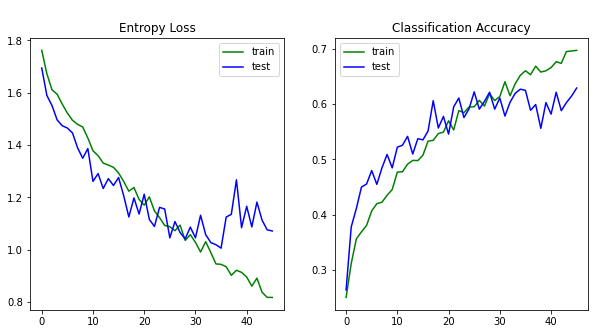

In [ ]:
# Build graphs of entropy loss and accuracy
graph_accuracy_loss(history)

In [ ]:
# As we see after 46 epochs our model didn't reached higher level of accuracy,
# and wasn't improving val_loss for 10 epochs so early stop was executed.
# and finished with the best accuracy score 62.9167%.
# Due the fact that calculations are computationally expensive for bigger picture size 
# we would recomment to use a model trained on small pictures of size 128*128px

<h3>Model with 3 VGG blocks, dropout, data augmentation and batch normalization</h3>
<h4>Trained for 85 max epochs and small size of pictures (128*128px) with Early stopping</h4>

In [ ]:
# Implementing Early stoping
ES = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience= 20)
# Save chekpoints to 
MC = ModelCheckpoint('best_model_bn.h5', monitor='val_accuracy', 
                     verbose=1, save_best_only=True, save_weights_only=False, mode='auto')

In [ ]:
# Let's improve our model's architecture:
# - add batch normalization between layers to speed up training

In [ ]:
# Define CNN model with added BatchNormalization
img_rows = 128
img_cols = 128
def model_blocks_bn():
    #reset_random_seeds()
    model = Sequential()
# Batch Normalization added to every block
# 1 block
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(img_rows, img_cols, 3)))
    model.add(BatchNormalization())
    model.add(Conv2D(32,(3,3), activation = 'relu', kernel_initializer = 'he_uniform', padding = 'same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    
# 2 block
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    
# 3 block
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
   
    
    model.add(Flatten())
    model.add(Dense(128, activation='relu', name='fc1'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(6, activation='softmax', name='output'))
    # Compilation of a model
    opt = SGD(lr=0.001, momentum=0.9) # Gradient descent (with momentum) optimizer.
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
# Create data generators
train_datagen = ImageDataGenerator(rescale=1. / 255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')
test_datagen = ImageDataGenerator(rescale=1. / 255)

# Create sets
training_set = train_datagen.flow_from_directory('train',
                                                 target_size=(img_rows, img_cols),
                                                 batch_size=batch_size,
                                                 class_mode='categorical')


test_set = test_datagen.flow_from_directory('val',
                                            target_size=(img_rows, img_cols),
                                            batch_size=batch_size, shuffle = False,
                                            class_mode='categorical')

# Define model
model_bn = model_blocks_bn()
# Fit model
history = model_bn.fit_generator(training_set, 
                              steps_per_epoch=len(training_set),
                              validation_data=test_set, 
                              validation_steps=len(test_set), 
                              epochs= 85, callbacks = [ES, MC])

Found 3360 images belonging to 6 classes.
Found 1440 images belonging to 6 classes.
Epoch 1/85
53/53 [==============================] - 19s 346ms/step - loss: 2.2054 - accuracy: 0.3445 - val_loss: 2.2370 - val_accuracy: 0.1681

Epoch 00001: val_accuracy improved from -inf to 0.16806, saving model to best_model_bn.h5
Epoch 2/85
53/53 [==============================] - 18s 339ms/step - loss: 1.5403 - accuracy: 0.4837 - val_loss: 4.9748 - val_accuracy: 0.1667

Epoch 00002: val_accuracy did not improve from 0.16806
Epoch 3/85
53/53 [==============================] - 18s 337ms/step - loss: 1.3735 - accuracy: 0.5216 - val_loss: 2.4959 - val_accuracy: 0.2222

Epoch 00003: val_accuracy improved from 0.16806 to 0.22222, saving model to best_model_bn.h5
Epoch 4/85
53/53 [==============================] - 18s 341ms/step - loss: 1.2607 - accuracy: 0.5533 - val_loss: 2.7830 - val_accuracy: 0.2118

Epoch 00004: val_accuracy did not improve from 0.22222
Epoch 5/85
53/53 [=============================

In [ ]:
# Create a new model instance to upload the best saved model there
# because our trained model finished training with the final accuracy not the best possible
model = model_blocks_bn()

# Load the previously saved weights
model.load_weights('best_model_bn.h5')
# Evaluate model

_, acc = model.evaluate_generator(test_set, steps=len(test_set), verbose=0)
print("Best accuracy: %.4f" % (acc * 100.0))

Accuracy: 63.4028


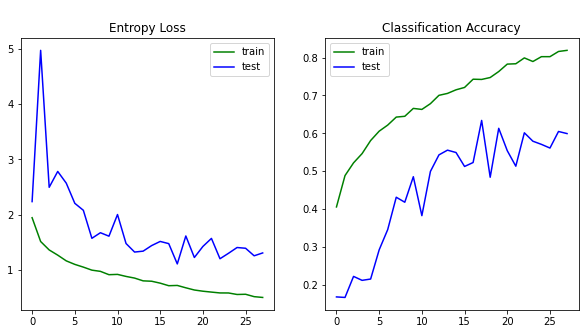

In [ ]:
# Build graphs of entropy loss and accuracy
graph_accuracy_loss(history)

In [ ]:
# As we see our model with batch normalization learns much faster.
#  but it is still has lower accuracy and has higher overfitting 
# so we are going to use our model_with_dropout (with data augmentation)

<h3>Model VGG16</h3>

In [ ]:
# The architecture of VGG16 was used here just for comparison of time needed to train this model

In [ ]:
# Implementing Early stoping and saving chekpoints
ES = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
MC = ModelCheckpoint('best_model__vgg16.h5', monitor='val_accuracy', 
                     verbose=1, save_best_only=True, save_weights_only=False, mode='auto')
img_rows = 224
img_cols = 224

# Define VGG16 model 
def VGG16():
    model = Sequential()
    model.add(Conv2D(input_shape=(img_rows,img_cols,3),filters=64, kernel_size=(3,3),padding="same", activation="relu"))
    model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
    model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
    
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
    
    model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
    
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
    
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2),name='vgg16'))
   
    model.add(Flatten(name='flatten'))
    model.add(Dense(units=4096, activation="relu", name='fc1'))
    model.add(Dense(units=4096,activation="relu", name='fc2'))
    model.add(Dense(units=6, activation='softmax', name='output'))
    
    opt = SGD(lr=0.001, momentum=0.9) # Gradient descent (with momentum) optimizer.
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
# Create sets
training_set = train_datagen.flow_from_directory('train',
                                                 target_size=(img_rows, img_cols),
                                                 batch_size=batch_size,
                                                 class_mode='categorical')


test_set = test_datagen.flow_from_directory('val',
                                            target_size=(img_rows, img_cols),
                                            batch_size=batch_size, shuffle = False,
                                            class_mode='categorical')

# Define model
model_vgg = VGG16()
# Fit model
history = model_vgg.fit_generator(training_set, 
                              steps_per_epoch=len(training_set),
                              validation_data=test_set, 
                              validation_steps=len(test_set), 
                              epochs= 85, callbacks=[ES, MC])

Found 3360 images belonging to 6 classes.
Found 1440 images belonging to 6 classes.
Epoch 1/100
53/53 [==============================] - 88s 1s/step - loss: 1.7917 - accuracy: 0.1704 - val_loss: 1.7912 - val_accuracy: 0.1674

Epoch 00001: val_accuracy improved from -inf to 0.16736, saving model to best_model__vgg16.h5
Epoch 2/100
53/53 [==============================] - 59s 1s/step - loss: 1.7911 - accuracy: 0.1846 - val_loss: 1.7907 - val_accuracy: 0.3139

Epoch 00002: val_accuracy improved from 0.16736 to 0.31389, saving model to best_model__vgg16.h5
Epoch 3/100
53/53 [==============================] - 59s 1s/step - loss: 1.7906 - accuracy: 0.2964 - val_loss: 1.7902 - val_accuracy: 0.3479

Epoch 00003: val_accuracy improved from 0.31389 to 0.34792, saving model to best_model__vgg16.h5
Epoch 4/100
53/53 [==============================] - 59s 1s/step - loss: 1.7899 - accuracy: 0.3157 - val_loss: 1.7896 - val_accuracy: 0.3556

Epoch 00004: val_accuracy improved from 0.34792 to 0.35556, 

In [ ]:
# Create a new model instance to upload the best saved model there
# because our trained model finished training with the final accuracy not the best possible
model = VGG16()

# Load the previously saved weights
model.load_weights('best_model__vgg16.h5')

# Evaluate model

_, acc = model.evaluate_generator(test_set, steps=len(test_set), verbose=0)
print("Best accuracy: %.4f" % (acc * 100.0))

Accuracy: 50.0694


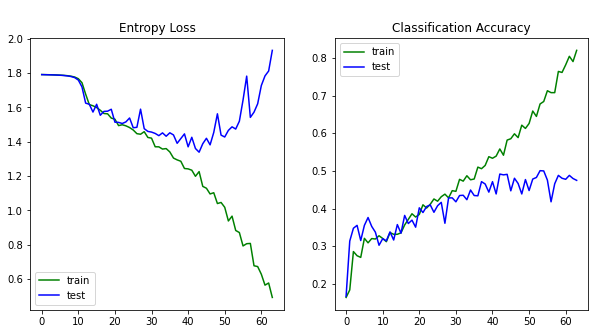

In [ ]:
# Build graphs of entropy loss and accuracy
graph_accuracy_loss(history)

In [ ]:
# As we see vgg16 needs a lot of time to train and didn't achieve higher level of accuracy
# for our dataset.
# And per project explanation we can't use pre-trained models

# Filters

In [ ]:
# For appear always the same first picture need have 'suffle=False' in flow_from_directory

# test_set contain 1440 images and they are divided in batch_size
# 1st batch_size has 64 images
# totally exist 22 batch_size with 64 images and 1 batch_size with 32 images

(64, 128, 128, 3)
(64, 6)


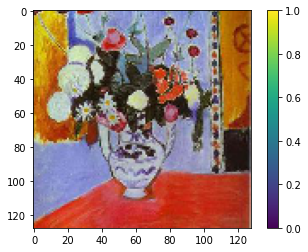

In [28]:
# Define images array
image_test = []
# Define images labels
labels_test = []
for image, label in test_set:
    image_test = image
    print(image_test.shape)
    labels_test = label
    print(labels_test.shape)
    
    
    # only for show if it is working    
    plt.figure()
    plt.imshow(image[0])
    plt.colorbar()
    plt.grid(False)
    plt.show()
    
    break

#### All layers in subplots ploting the same number of filters 

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18_input (InputLayer) [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 128, 128, 32)      896       
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 128, 128, 32)      9248      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 64, 64, 64)        18496     
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 64, 64, 64)        36928     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 32, 32, 64)        0   

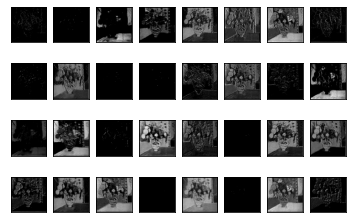

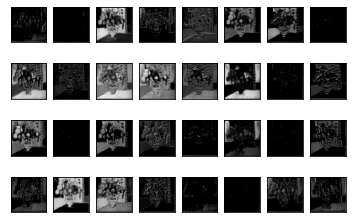

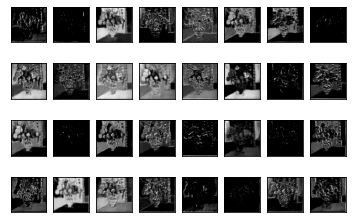

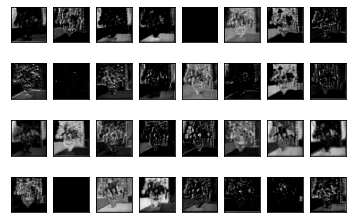

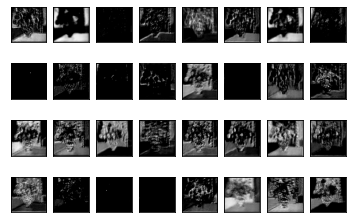

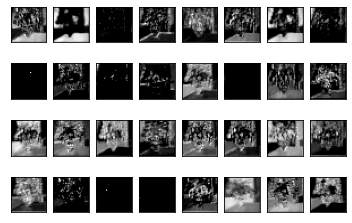

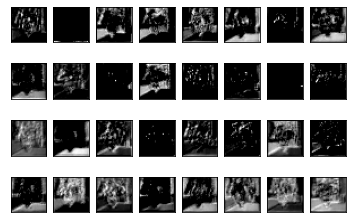

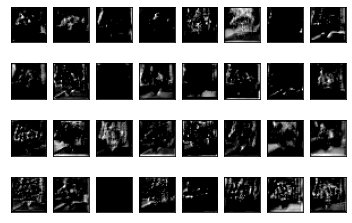

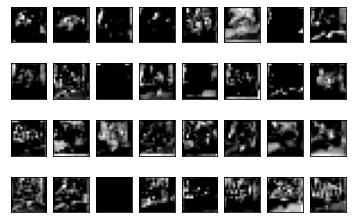

In [30]:
# Visualize feature maps output from each block in the vgg model

# load the model
model = model_best

# show all filters
ixs = [0,1,2,3,4,5,6,7,8]
outputs = [model.layers[i].output for i in ixs]
model = Model(inputs=model.inputs, outputs=outputs)
model.summary()
# load the image with the required shape

# Define only one picture to try if it is working with image test
img = image_test[0]

# convert the image to an array
img = img_to_array(img)
# expand dimensions so that it represents a single 'sample'
img = expand_dims(img, axis=0)
# get feature map for first hidden layer
feature_maps = model.predict(img)
# plot the output from each block

# plot all 32 maps in an 4x8 squares
# as the 1st number of filters defined in the model was 32
rows = 4
cols = 8

for fmap in feature_maps:
    # plot all 32 maps in an 4x8 squares
    ix = 1
    
    for _ in range(rows):
        
        for _ in range(cols):
            # specify subplot and turn of axis
            ax = pyplot.subplot(rows, cols, ix)
            ax.set_xticks([])
            ax.set_yticks([])
            
            
            # plot filter channel in grayscale
            pyplot.imshow(fmap[0, :, :, ix-1],
                          cmap='gray'
                         )
            ix += 1

# show the figure
    pyplot.show()


#### Each layer with the number of filters that this layer has

In [31]:
# Define function
def filters(layer_number, rows, cols, picture_n):
    model = model_best
    # redefine model to output right after the first hidden layer
    model = Model(inputs=model.inputs, outputs=model.layers[layer_number].output)
    #model.summary()
    # load the image with the required shape
    img = image_test[picture_n]
    # convert the image to an array
    img = img_to_array(img)
    # expand dimensions so that it represents a single 'sample'
    img = expand_dims(img, axis=0)
    # get feature map for first hidden layer
    feature_maps = model.predict(img)
    # plot all 64 maps in an 8x8 squares
    rows = rows
    cols = cols
    ix = 1
    for _ in range(rows):
        for _ in range(cols):
            # specify subplot and turn of axis
            ax = pyplot.subplot(rows, cols, ix)
            ax.set_xticks([])
            ax.set_yticks([])
            # plot filter channel in grayscale
            pyplot.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
            ix += 1
    # show the figure
    pyplot.show()
    return

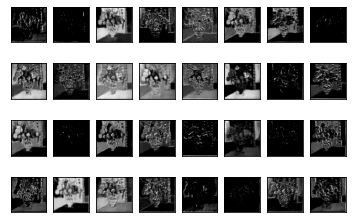

In [32]:
filters(layer_number = 2, rows = 4, cols = 8, picture_n = 0)

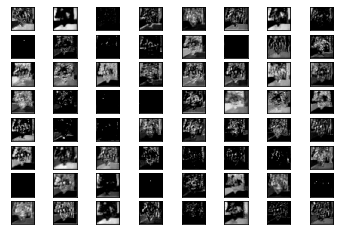

In [33]:
filters(layer_number = 5, rows = 8, cols = 8, picture_n = 0)

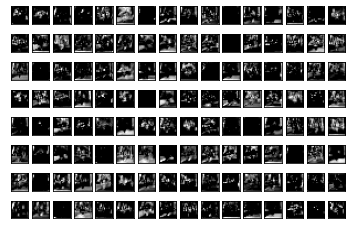

In [34]:
filters(layer_number = 8, rows = 8, cols = 16, picture_n = 0)

# Predict artist

In [35]:
predictions = model_best.predict(test_set)
predictions[0]

array([9.9981004e-01, 8.6796506e-05, 1.2181960e-06, 3.2554435e-05,
       3.8441627e-05, 3.1050298e-05], dtype=float32)

In [36]:
# Prediction label
print(np.argmax(predictions[0]))
print(predictions[0])

# Real label
print(np.argmax(labels_test[0]))
print(labels_test[0])

0
[9.9981004e-01 8.6796506e-05 1.2181960e-06 3.2554435e-05 3.8441627e-05
 3.1050298e-05]
0
[1. 0. 0. 0. 0. 0.]


In [37]:
# autors name to add in graph below
labels = ['Matisse', 'Monet', 'Pissaro', 'Renoir', 'Sargent', 'VanGogh']

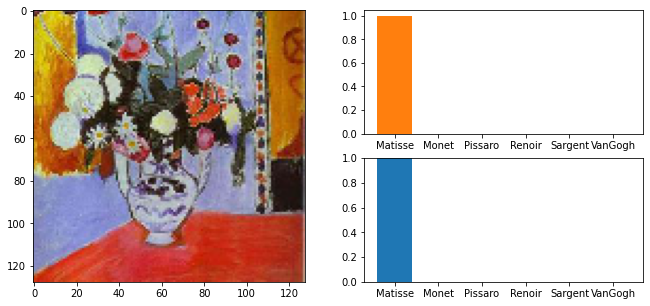

In [40]:
plt.figure(figsize=(11,5))
plt.subplot(1,2,1)

# select one picture in test
plt.imshow(image_test[0])
plt.subplot(2,2,2)
plt.bar(labels, labels_test[0],color = 'C1')
plt.subplot(2,2,4)
plt.bar(labels, predictions[0])
plt.ylim(0, 1)
plt.show()

In [2]:
# ! git clone https://github.com/svasylyeva/AWS

Cloning into 'AWS'...
remote: Enumerating objects: 4824, done.
remote: Counting objects: 100% (4824/4824), done.
remote: Compressing objects: 100% (4824/4824), done.
remote: Total 4824 (delta 4), reused 4816 (delta 0), pack-reused 0
Receiving objects: 100% (4824/4824), 73.31 MiB | 43.00 MiB/s, done.
Resolving deltas: 100% (4/4), done.


In [3]:
cd AWS

/content/AWS


In [6]:
!ls

train  val


In [5]:
rm Code_128px_35_folders.ipynb